In [248]:
using Revise, HarmonicBalance,Latexify,PyPlot

## Arnold tongue of a single parametron

In [224]:
@variables ω₁, ω, γ,λ, t, T, α₁, x(t)

#sympy object for the equation of motion
natural_equation = [d(d(x, t),t) + ω₁^2*(1-λ*cos(2*ω*t)) * x + γ*d(x,t)  + α₁*x^3] 

dEOM = HarmonicBalance.DifferentialEquation(natural_equation, [x])

HarmonicBalance.add_harmonic!(dEOM, x, ω) # x will rotate at ω

@time averagedEOM = HarmonicBalance.get_harmonic_equations(dEOM, slow_time=T, fast_time=t)
@time problem = HarmonicBalance.Problem(averagedEOM)

  0.140340 seconds (647.16 k allocations: 27.761 MiB)
  0.016536 seconds (42.87 k allocations: 1.624 MiB, 0.00% compilation time)


2 algebraic equations for steady states
Variables: u1, v1
Parameters: α₁, ω, γ, ω₁, λ
Symbolic Jacobian: true


# 1D sweep

In [191]:
fixed_parameters =  ParameterList([(ω₁, 1.),(γ, 0.001 ),(α₁,  -1.),(λ,0.05)])
swept_parameters = ParameterRange(ω =>LinRange(0.7,1.2,50))

soln_1d = HarmonicBalance.get_steady_states(problem, swept_parameters, fixed_parameters; random_warmup=false, threading=false,sorting="naive");
print(soln_1d)

A steady state result for 50 parameter points

Solution branches:   5
   of which real:    5
   of which stable:  3

Classes: stable, physical, Hopf, binary_labels


In [186]:
function plot_1D_solutions_alt(res::Result; x::String, y::String, x_scale=1.0, y_scale=1.0, marker="o",xscale="linear",yscale="linear",plot_only=["physical"],marker_classification="stable",filename=nothing)
    _set_plotting_settings()
    length(size(res.solutions)) != 1 && error("1D plots of not-1D datasets are usually a bad idea.")

    X = HarmonicBalance.transform_solutions(res, x)
    Y = HarmonicBalance.transform_solutions(res, y) # first transform, then filter
    
    #retrieve data from specific branch
    relevant_indices = findall(x->x==true, [!all(isnan.(getindex.(Y, branch))) for branch in 1:length(Y[1])])
    X = x_scale .* [p[relevant_indices] for p in X]
    Y = y_scale .* [p[relevant_indices] for p in Y]

    f,ax = HarmonicBalance.subplots(1,1,figsize=(6,5))

    #filtering of the solutions according to keyword arguments
    "stable" in plot_only && "physical" ∉ plot_only && error("Stability is not defined for unphysical solutions!")
    ~(sum([class in keys(res.classes) for class in plot_only])==length(plot_only)) && error("Class not found. Solutions are classified according to ", keys(res.classes))
    ("binary_labels" in plot_only) && print("Binary label is not Boolean and thus was ignored in plotting")
    
    for class in plot_only 
        if  class!="binary_labels" 
            Y = HarmonicBalance.filter_solutions.(Y, res.classes[class])
        end
    end

    sol_type, not_sol_type = HarmonicBalance._classify_plot_data(res, marker_classification)

    Ys, Yu = HarmonicBalance.filter_solutions.(Y, res.classes[sol_type]), HarmonicBalance.filter_solutions.(Y, [.!el for el in res.classes[sol_type]])
    lines = ax.plot(X, Ys, marker) #Nan solutions are ignored 
    ax.set_prop_cycle(nothing) #reset color cycler state (NaN solutions aren't shown but the color cycler runs)
    append!(lines,ax.plot(X, Yu, "X"))

    leg2 = [plt.Line2D([0], [0], marker=marker, color="w", label=sol_type, markerfacecolor="k", markersize=10),
            plt.Line2D([0], [0], marker="X", color="w", label=not_sol_type,markerfacecolor="k", markersize=10)] 

    if !isnothing(filename)
        xdata,ydata = [line.get_xdata() for line in lines], [line.get_ydata() for line in lines]
        markers = [line.get_marker() for line in lines]
        marker_dict = Dict(marker=>sol_type,"X"=>not_sol_type)
        JLD2.save(_jld2_name(filename), Dict(string(x) => xdata,string(y)=>ydata,"marker_dict"=>marker_dict,"markers"=>markers))
    end

    ax.set_xlabel(Latexify.latexify(x),fontsize=24) 
    ax.set_ylabel(Latexify.latexify(y),fontsize=24) 
    print(relevant_indices)
    
    ignored_idx = [all(isnan.(line.get_ydata())) for line in lines]
    leg1 = ax.legend(string.(collect(1:sum(.~ignored_idx))))
    ax.add_artist(leg1)
    
    ax.legend(handles=leg2,loc="center right") 
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    lines
end

plot_1D_solutions_alt (generic function with 1 method)

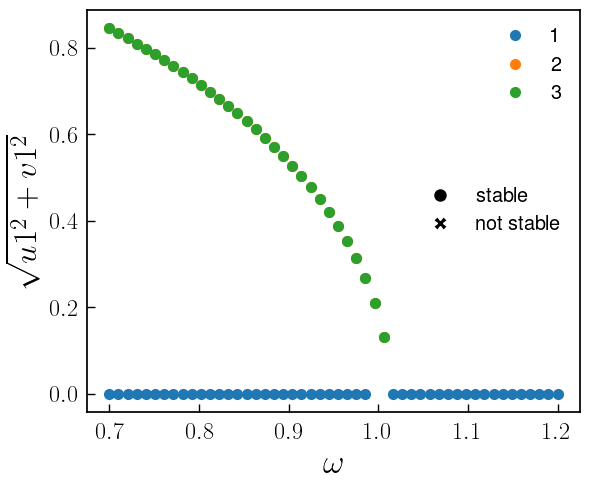

In [193]:
lines = HarmonicBalance.plot_1D_solutions(soln_1d, x="ω", y="sqrt(u1^2 + v1^2)", plot_only=["physical","stable"])#,filename="plot_1D");

In [50]:
using JLD2
lines = JLD2.load("plot_1D.jld2")

Dict{String, Any} with 4 entries:
  "markers"           => ["o", "o", "o", "o", "o", "X", "X", "X", "X", "X"]
  "sqrt(u1^2 + v1^2)" => Vector{ComplexF64}[[0.0+5.11571e-48im, 0.0+0.0im, 0.0+…
  "marker_dict"       => Dict("X"=>"not custom class", "o"=>"custom class")
  "ω"                 => Vector{ComplexF64}[[0.7+0.0im, 0.710204+0.0im, 0.72040…

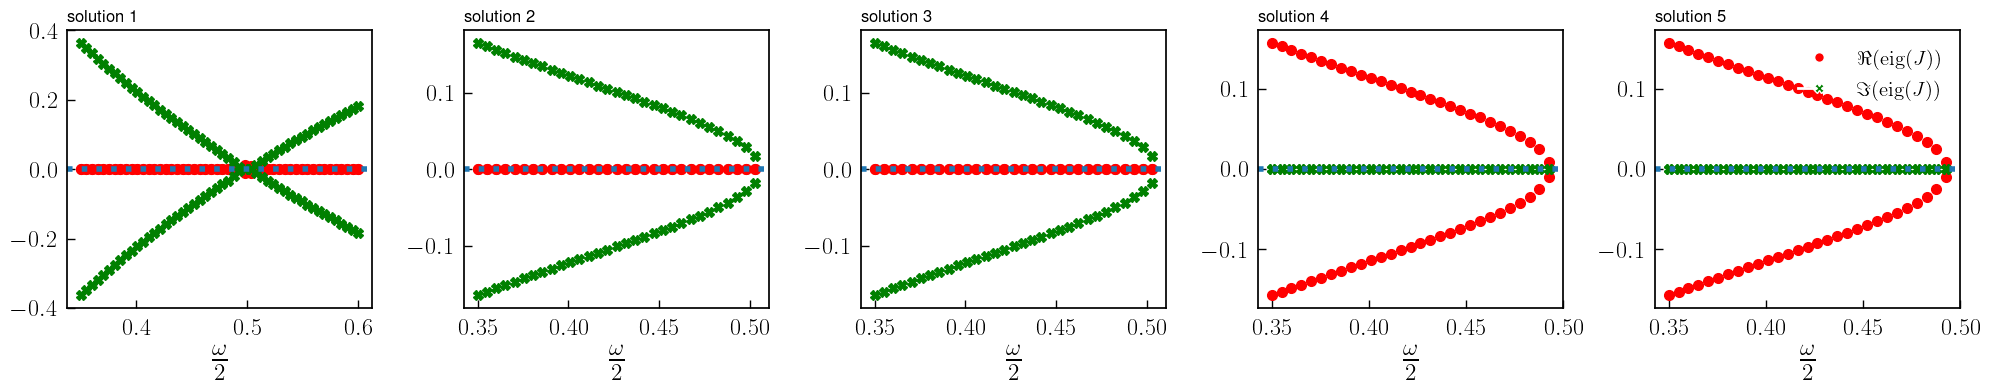

In [63]:
f,ax = HarmonicBalance.subplots(1,5,figsize=(4*5,4))
HarmonicBalance.plot_1D_jacobian_eigenvalues(soln_1d, x="ω/2", physical=true, stable=false,filename="plot_1D_jacobian",ax=ax);

In [52]:
lines = JLD2.load("plot_1D_jacobian.jld2")
lines["im"]["data"]

Dict{String, Vector{Vector{Float64}}} with 2 entries:
  "ω/2"          => [[0.35, 0.355102, 0.360204, 0.365306, 0.370408, 0.37551, 0.…
  "im part(eig)" => [[0.363847, -0.348476, -0.333395, 0.318592, 0.304055, 0.289…

# single parametron, 2D sweeps

In [53]:
fixed_parameters = ParameterList([(ω₁, 1.),(γ, 0.05),(α₁, -0.99)])

swept_parameters = ParameterRange(ω => collect(LinRange(0.8,1.2,100)), λ => collect(LinRange(0.001,0.6,120)))

#best results for random_warmup=false, so beginning from a total degree homotopy and pass parameters one by one to the solver
phase_diagram = HarmonicBalance.get_steady_states(problem, swept_parameters, fixed_parameters; random_warmup=false, threading=false,sorting="naive")

A steady state result for 12000 parameter points

Solution branches:   5
   of which real:    5
   of which stable:  3

Classes: stable, physical, Hopf, binary_labels


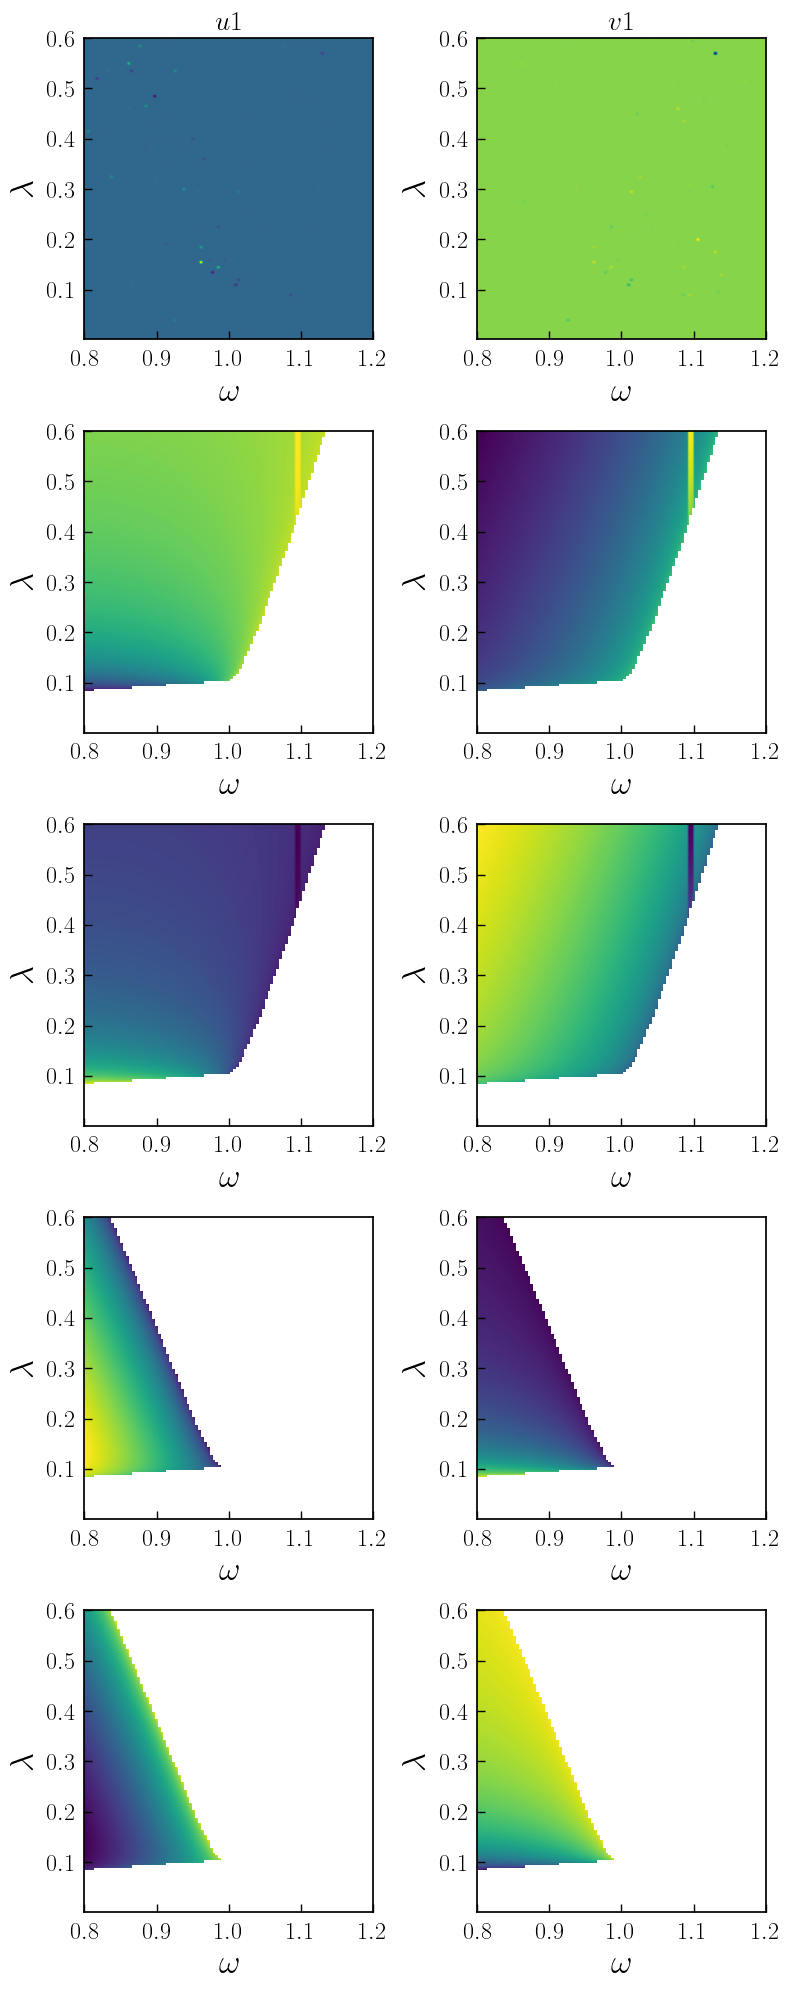

In [54]:
HarmonicBalance.plot_2D_solutions(phase_diagram,filename="plot_2D_solutions")

In [55]:
data_2D = JLD2.load("plot_2D_solutions.jld2")
data_2D["panel (2,2)"]

Dict{Any, Any} with 4 entries:
  "solution #"                => 2
  "data"                      => [-0.938791 -0.934111 … NaN NaN; -0.93694 -0.93…
  "(ω_min ω_max λ_min λ_max)" => [0.8, 1.2, 0.001, 0.6]
  "variable"                  => "v1"

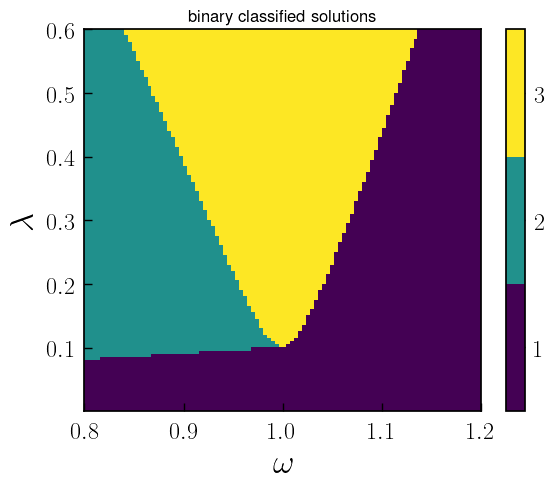

(PyObject <matplotlib.image.AxesImage object at 0x7ff799e14760>, 3)

In [249]:
HarmonicBalance.plot_2D_phase_diagram(phase_diagram, stable=false,observable="binary",filename="plot_2D_phase_diagram")

In [57]:
data_pd_2D = JLD2.load("plot_2D_phase_diagram.jld2")

Dict{String, Any} with 3 entries:
  "observable"                => "binary"
  "data"                      => [2 2 … 1 1; 2 2 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 …
  "(ω_min ω_max λ_min λ_max)" => [0.8, 1.2, 0.001, 0.6]

In [228]:
#HarmonicBalance.plot_2D_phase_diagram(phase_diagram, x="ω", y="λ", stable=false);
HarmonicBalance.plot_2D_phase_diagram_interactive(phase_diagram, stable=true, nrows=2,ncols=2,cut_dim="2",cut_type="solutions",observable="nsols",marker_classification="ω^15* sqrt(u1^2 + v1^2) < 0.1" )

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff790f5c6a0>

In [231]:
#HarmonicBalance.plot_2D_phase_diagram(phase_diagram, x="ω", y="λ", stable=false);
HarmonicBalance.plot_2D_phase_diagram_interactive(phase_diagram, stable=true, nrows=1,cut_dim="1",cut_type="transform",observable="binary",string_f=["u1^2+v1^2"])

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff7321074f0>

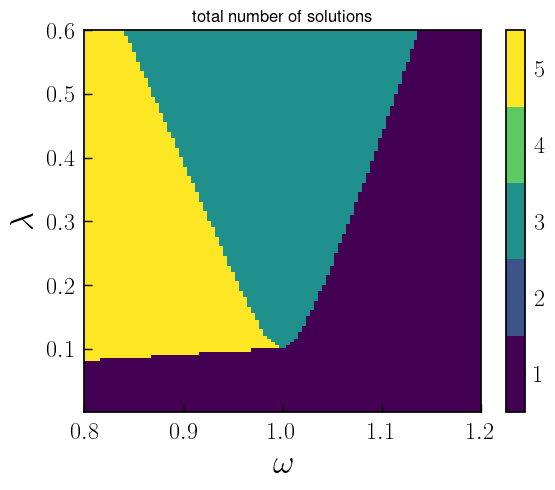

(PyObject <matplotlib.image.AxesImage object at 0x7ff731d49040>, 5)

In [232]:
HarmonicBalance.plot_2D_phase_diagram(phase_diagram, stable=false,observable="nsols")

In [233]:
#HarmonicBalance.plot_2D_phase_diagram(phase_diagram, x="ω", y="λ", stable=false);
HarmonicBalance.plot_2D_phase_diagram_interactive(phase_diagram, stable=true, nrows=2,ncols=2,cut_dim="1",cut_type="solutions",string_f="a")

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff731a68e50>

In [221]:
#HarmonicBalance.plot_2D_phase_diagram(phase_diagram, x="ω", y="λ", stable=false);
HarmonicBalance.plot_2D_phase_diagram_interactive(phase_diagram, stable=false, nrows=4,cut_dim="1",cut_type="jacobian_eigenvalues")

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff7a225ebb0>

# coupled parametrons

In [234]:
@variables x, y, ω₁, ω₂,ω, γ,λ, t, T, ω, α₁, α₂, J;
@variables x(t), y(t);

In [235]:
#sympy object for the equation of motion
natural_equation = [d(d(x, t),t) + ω₁^2*(1-λ*cos(2*ω*t)) * x + γ*d(x,t)  + α₁*x^3 - J*y , 
                    d(d(y,t),t)  + ω₂^2*(1-λ*cos(2*ω*t)) * y + γ*d(y,t)  + α₂*y^3 - J*x] 


dEOM_coupled = HarmonicBalance.DifferentialEquation(natural_equation, [x, y])

HarmonicBalance.add_harmonic!(dEOM_coupled, x, ω) # x will rotate at ω
HarmonicBalance.add_harmonic!(dEOM_coupled, y, ω) # y will rotate at ω

show(dEOM_coupled)

@time averagedEOM_coupled = HarmonicBalance.get_harmonic_equations(dEOM_coupled, slow_time=T, fast_time=t)
@time problem_coupled = HarmonicBalance.Problem(averagedEOM_coupled)

"equations"

OrderedCollections.OrderedDict{Symbolics.Num, Symbolics.Equation} with 2 entries:
  x(t) => α₁*(x(t)^3) + γ*Differential(t)(x(t)) + (ω₁^2)*(1 - λ*cos(2t*ω))*x(t)…
  y(t) => α₂*(y(t)^3) + γ*Differential(t)(y(t)) + (ω₂^2)*(1 - λ*cos(2t*ω))*y(t)…

"harmonics"

OrderedCollections.OrderedDict{Symbolics.Num, Vector{Symbolics.Num}} with 2 entries:
  x(t) => [ω]
  y(t) => [ω]

  1.688055 seconds (4.10 M allocations: 210.471 MiB, 86.88% compilation time)
  0.952773 seconds (1.73 M allocations: 99.854 MiB, 5.80% gc time, 94.82% compilation time)


4 algebraic equations for steady states
Variables: u1, v1, u2, v2
Parameters: α₁, ω, γ, ω₁, λ, J, α₂, ω₂
Symbolic Jacobian: true


# 2D phase diagram for two coupled parametrons

[1, 3, 5, 7, 9]

In [236]:
fixed_parameters = ParameterList([(ω₁, 1.),( ω₂, 1. ),(γ, 0.001 ),(α₁,  -0.01),(α₂, -0.01),(J,0.)])
swept_parameters = ParameterRange(ω => LinRange(0.,1.5, 100), λ => LinRange(0.001,0.6, 100))
result_coupled = HarmonicBalance.get_steady_states(problem_coupled, swept_parameters, fixed_parameters; random_warmup=true, threading=false)

Solving for 10000 parameters... 100%|███████████████████| Time: 0:00:21
  # parameters solved:  10000
  # paths tracked:      250000


A steady state result for 10000 parameter points

Solution branches:   25
   of which real:    25
   of which stable:  22

Classes: stable, physical, Hopf, binary_labels


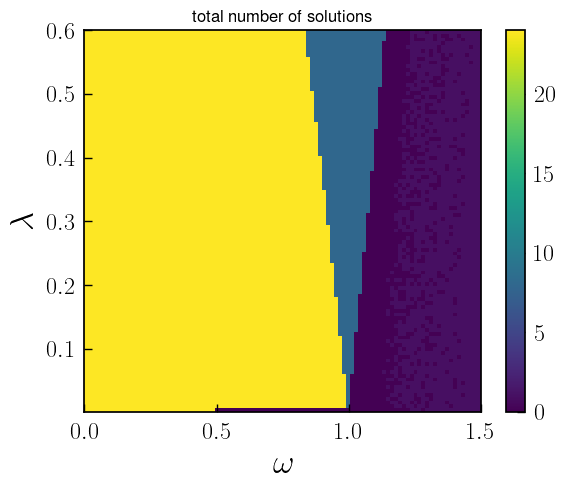

In [250]:
HarmonicBalance.plot_2D_phase_diagram(result_coupled, stable=false);

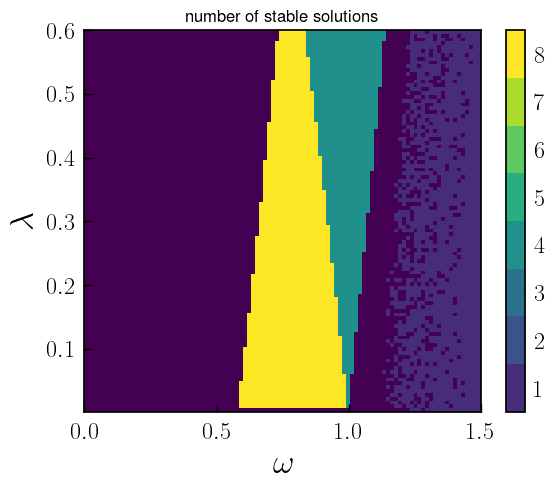

In [238]:
HarmonicBalance.plot_2D_phase_diagram(result_coupled, stable=true);

In [24]:
#HarmonicBalance.plot_2D_phase_diagram(phase_diagram, x="ω", y="λ", stable=false);
HarmonicBalance.plot_2D_phase_diagram_interactive(result_coupled, stable=false, nrows=3, ncols=3,cut_dim="1",cut_type="solutions",observable="nsols")

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/hrochan/.julia/packages/PyCall/3fwVL/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'AttributeError'>
AttributeError("'NoneType' object has no attribute 'get_array'")
  File "/usr/lib/python3/dist-packages/matplotlib/figure.py", line 2215, in colorbar
    cb = cbar.colorbar_factory(cax, mappable, **cb_kw)
  File "/usr/lib/python3/dist-packages/matplotlib/colorbar.py", line 1640, in colorbar_factory
    cb = Colorbar(cax, mappable, **kwargs)
  File "/usr/lib/python3/dist-packages/matplotlib/colorbar.py", line 1158, in __init__
    if mappable.get_array() is not None:
